This script takes cleaned data fron FEMA's data set of national flood insurance program claims and attempts to build a model that predicts individual home damage distributions.

In [167]:
#import pip
#pip.main(['install', 'xgboost'])
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import random
import pick
from sklearn import preprocessing
from sklearn import model_selection as ms
from sklearn import neural_network as nn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
 

# code below creates a progres bar that can be deployed in any code chunk
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
    

In [81]:
# get/change working directory
print(os.getcwd())
os.chdir("/home/dylan/Dropbox/Research/Hurricane Damage Predictions")

/home/dylan/Dropbox/Research/Hurricane Damage Predictions


In [82]:
# import cleaned data 
data = pd.DataFrame(pd.read_csv("./Data/nfip_data_cleaned.csv"))
data.info() # inspect variables and types

# use only first 10000 observations to speed up testing of code
#data = data[1:1000]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234846 entries, 0 to 1234845
Data columns (total 44 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   source                       1234846 non-null  object 
 1   state                        1234846 non-null  object 
 2   fips                         1233209 non-null  float64
 3   storm_dist                   803989 non-null   float64
 4   tot_precip                   541584 non-null   float64
 5   vmax_sust                    803989 non-null   float64
 6   vmax_gust                    803989 non-null   float64
 7   sust_dur                     803989 non-null   float64
 8   storm_id                     803989 non-null   object 
 9   start_date                   803989 non-null   object 
 10  end_date                     803989 non-null   object 
 11  flood_insurance              1234846 non-null  int64  
 12  year                         1234846 non-n

In [83]:
# keep observations from the nfip claims data set
#train only on major hurricane (cat 3 or greater)
data = data[data['max_hurr_cat']>=3]
data.describe()

# dropping missing target variable
data.dropna(axis=0, inplace=True)
data.describe()

#data.describe()
#data.info()

,fips,storm_dist,tot_precip,vmax_sust,vmax_gust,sust_dur,flood_insurance,year,flood_structure_claim,flood_structure_coverage,...,primary_res,hurr_cat,max_hurr_cat,assumed_home_value,assumed_home_value_censored,inflation_factor2020,avg_county_home_value,flood_structure_claim_posv,coastal_state,coastal_county
count,306425.000000,306425.000000,306425.000000,306425.000000,306425.000000,306425.000000,306425.0,306425.000000,306425.000000,3.064250e+05,...,306425.000000,306425.000000,306425.0,3.064250e+05,306425.000000,306425.000000,3.064250e+05,306425.000000,306425.0,306425.0
mean,26565.020615,51.108572,154.345368,33.903715,50.516536,553.940344,1.0,2004.920555,38859.692642,1.379207e+05,...,0.848834,0.820987,4.0,1.379207e+05,0.179946,0.757982,1.818316e+05,0.258484,1.0,1.0
std,13184.209297,37.316818,52.869646,9.106457,13.568621,292.184520,0.0,2.584723,53913.733229,7.255572e+04,...,0.358211,0.739009,0.0,7.255572e+04,0.384143,0.051876,7.868480e+04,0.376987,0.0,0.0
min,1003.000000,0.456700,0.000000,1.711820,2.550611,0.000000,1.0,1989.000000,0.000000,0.000000e+00,...,0.000000,0.000000,4.0,0.000000e+00,0.000000,0.480601,2.868458e+04,0.000000,1.0,1.0
25%,22051.000000,26.667692,116.700000,26.249893,39.112341,390.000000,1.0,2004.000000,0.000000,8.000000e+04,...,1.000000,0.000000,4.0,8.000000e+04,0.000000,0.732518,1.367382e+05,0.000000,1.0,1.0
50%,22071.000000,44.070459,170.600000,36.679236,54.652062,675.000000,1.0,2005.000000,11845.730000,1.250000e+05,...,1.000000,1.000000,4.0,1.250000e+05,0.000000,0.757174,1.664728e+05,0.066885,1.0,1.0
75%,37019.000000,53.675992,185.500000,39.645569,59.071898,675.000000,1.0,2005.000000,61989.260000,2.000000e+05,...,1.000000,1.000000,4.0,2.000000e+05,0.000000,0.757174,1.828021e+05,0.395723,1.0,1.0
max,51810.000000,199.975503,369.100000,56.608689,84.346946,2070.000000,1.0,2011.000000,450000.000000,7.500000e+06,...,1.000000,3.000000,4.0,7.500000e+06,1.000000,0.872170,1.580496e+06,2.948458,1.0,1.0


In [84]:
# define prediction target (y) and features (x) 
target = 'flood_structure_claim'
y = data[[target]]
x = data[["storm_dist","tot_precip","vmax_sust","vmax_gust",
              "sust_dur","coastal_state","coastal_county",
              "total_flood_damage_censored","freeboard_ft",
              "base_flood_elv_ft","basement","crawlspace","elevated_building",
              "a_zone","v_zone","x_zone","sfha","floors","post_firm",
              "primary_res","avg_county_home_value","assumed_home_value",
              "assumed_home_value_censored"]]

# one hot encode categorical features
region = pd.get_dummies(data.coastal_region, prefix='region')
x = x.join(region)

#state = pd.get_dummies(data.state, prefix='state')
#x = x.join(state)

# split x_scaled into train and test
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size = 0.10)

MSE:  607862552.2380704
RMSE:  24654.868732931238
Mean Residual:  -71.84617546367755


/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

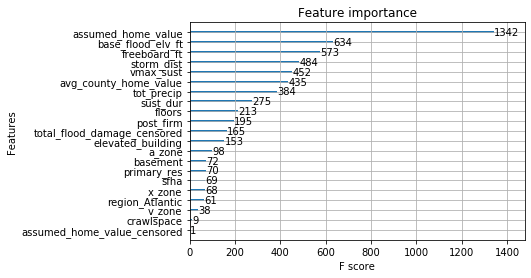

In [85]:
# run xgb model without any hyper parameter tuning 
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state = 25)
xgb_model.fit(x_train, y_train)

# predict on test set
y_pred = xgb_model.predict(x_test)

# calculate mse and rmse
error_df = y_test
error_df['y_pred'] = y_pred
error_df['resids'] = error_df[target] - error_df['y_pred']
error_df['sq_error'] = error_df['resids']**2
mse_raw = error_df['sq_error'].mean()
print("MSE: ", mse_raw)
rmse_raw = np.sqrt(mse_raw)
print("RMSE: ", rmse_raw)
print("Mean Residual: " ,error_df['resids'].mean())

# plot feature importance 
xgb.plot_importance(xgb_model)

In [86]:
# hyper parameter tuning via a random search
tune = "yes" # switch to "no" to by pass hyperparameter tuning
if tune == "yes":
    # perform some simple hyper parameter tuning using a grid search
    xgb_model = xgb.XGBRegressor()
    parameters = {'nthread':[1], # number of threads to use (may become slower)
                  'objective':['reg:squarederror'],
                  'learning_rate': [0.005,.01,.02,.03,0.04], #so called `eta` value
                  'max_depth': [6, 7,8,9,10],
                  'min_child_weight': [6,7,8,9,10,11,12],
                  'silent': [1],
                  'subsample': [0.5,0.6,0.7,0.8,0.9],
                  'colsample_bytree': [0.2,0.3,0.4,0.5,0.7,0.9],
                  'n_estimators': [500]}

#     xgb_grid = ms.RandomizedSearchCV(xgb_model,
#                             parameters,
#                             cv = 3,
#                             n_jobs = 5,
#                             verbose=True)

    xgb_grid = ms.RandomizedSearchCV(xgb_model, parameters, n_iter= 10, cv=3, random_state=1, n_jobs = 5, verbose = True)
    xgb_grid.fit(x_train,
             y_train)

    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    
    
    # store best parameter values
    best_params = xgb_grid.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/dylan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 11.6min finished


[16:23:24] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.7913781707504989
{'subsample': 0.6, 'silent': 1, 'objective': 'reg:squarederror', 'nthread': 1, 'n_estimators': 500, 'min_child_weight': 9, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.9}


In [87]:
#params = {'subsample': 0.6, 'silent': 1, 'objective': 'reg:squarederror', 'nthread': 1, 'n_estimators': 500, 'min_child_weight': 9, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.9}

# run xgboost again using best hyper parameters
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state = 25, 
                                 colsample_bytree = best_params['colsample_bytree'],
                                learning_rate = best_params['learning_rate'],
                                max_depth = best_params['max_depth'],
                                min_child_weight = best_params['min_child_weight'],
                                n_estimators = best_params['n_estimators'],
                                subsample = best_params['subsample'])
xgb_model.fit(x_train, y_train)

# predict on test set
y_pred = xgb_model.predict(x_test)

# calculate mse and rmse
error_df = y_test
error_df['y_pred'] = y_pred
error_df['resids'] = error_df[target] - error_df['y_pred']
error_df['sq_error'] = error_df['resids']**2
mse_tuned = error_df['sq_error'].mean()


/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [88]:
# compare error between origonal model and model with feature selection and hyper parameter tuning applied
print("MSE (Tuned): ", mse_tuned,"  ","MSE (Original): ", mse_raw)
rmse_tuned = np.sqrt(mse_tuned)
print("RMSE (Tuned): ", rmse_tuned,"  ","RMSE (Original): ", rmse_raw)


MSE (Tuned):  586285217.0928537    MSE (Original):  607862552.2380704
RMSE (Tuned):  24213.327261920316    RMSE (Original):  24654.868732931238


At this point there is a trained XGB model. The goal now is to create a distribution of predicted damages based on the uncertainty of future hurricane conditions. To generate distributions of hurricane conditions I am applying K-Means clustering to generate clusters of similar households. Then for each observation in the test set, a distribution of damages can be constructed by the following:

1) Select and observations from the test test, call it the observation of interest (OOI)

2) Identify which cluster the observation belongs to

3) Extract historical hurricane conditions from all observations in that cluster

4) For each variable in the OOI related to the historical hurricane condition, replace it by randomly drawing values from the hurricane conditions identified in step 3

5) Predict damages using the trained XGB model

6) Repeat N times 

7) The N individual damage predictions form the distribution.


Text(0, 0.5, 'Within Cluster SSE')

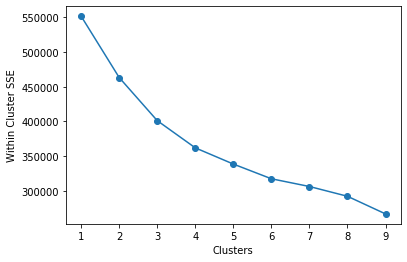

In [89]:
# exclude hurricane variables when clustering
hurricane_vars = ['storm_dist','tot_precip','vmax_sust','vmax_gust','sust_dur']

# Scale the test data before trying to cluster
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test.drop(hurricane_vars, axis = 1))


# decide how many clusters to use based on "elbow method"
distortion = [] # i.e. within cluster sse

max_clusters = 10 # define max number of clusters to consider
for k in range(1,max_clusters): 
    km = KMeans(
        n_clusters=k, init='random',
        n_init=20, max_iter=500,
        tol=0.001, random_state=0
    )
    km.fit(x_test_scaled)
    distortion.append(km.inertia_)
    #print(km.inertia_)
# plot
plt.plot(range(1, max_clusters), distortion, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Within Cluster SSE')


In [90]:
# Pick the number of clusters to use
clusters = 6

# cluster using K means choosen number of clusters
km = KMeans(
    n_clusters=clusters, init='random',
    n_init=20, max_iter=500, 
    tol=1e-04, random_state=0
)
clusters = km.fit_predict(x_test_scaled)

# add the cluster number to the unscaled test data data
x_test['cluster'] = clusters

# check and make sure cluster column has been added 
x_test['cluster'].head()


/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


454624    1
430601    5
716003    0
704848    0
715719    5
Name: cluster, dtype: int32

In [91]:
# Construct predicted damage distributions using a monte-carlo style technique

# combine y_test and x_test
test_data = x_test
test_data[target] = y_test[target]

for k in range(len(test_data)-1): # iterate over each row of the test set
    ooi = test_data[k:k+1] # select a single observation
    trained_on_features = ooi.columns # store column names to slice with later

    # identify which cluster the observation belongs to
    ooi_cluster = int(ooi['cluster'])

    # extract historical hurricane conditions from all observations in that cluster
    hurricane_conditions = test_data[test_data.cluster.eq(ooi_cluster)] # filter based on cluster number
    hurricane_conditions = hurricane_conditions[hurricane_vars] # keep only variables related to hurricane conditions
    hurricane_conditions = hurricane_conditions.dropna() # drop any missing values

    reps = 500 # reps used to form the predicted damage distribution
    counter = 0 # counter for while loop
    damage_estimates = np.array([]) # initialize an array to store the damage estimates
    while counter < reps:
        counter = counter + 1
        # for each column in the selected observation related to the historical hurricane condition, 
        # replace it by randomly drawing values from the hurricane conditions identified above
        random_row = random.randint(1,len(hurricane_conditions)-1) # pick a random integer less than the number of rows in the hurricane conditions
        random_conditions = hurricane_conditions[random_row:random_row+1] # pick out a set of random conditions.
        
        # Note: its important not to mix conditions from different observations since
        # the conditions set of conditions need to be reasonable as a whole 
        # (for example: mixing observations may lead to peak wind gust speed being lower than sustained wind speed)
        
        # to generate more variation, perturb each observation by up to +/- 5 percent
        for t in range(len(random_conditions.columns)):
            disturbance = 1+random.uniform(-.05, .05)
            random_conditions[random_conditions.columns[t]] = random_conditions[random_conditions.columns[t]] * disturbance

        # final random conditions
        storm_dist = float(random_conditions.loc[:,'storm_dist'])
        tot_precip = float(random_conditions.loc[:,'tot_precip'])
        vmax_sust = float(random_conditions.loc[:,'vmax_sust'])
        vmax_gust = float(random_conditions.loc[:,'vmax_gust'])
        sust_dur = float(random_conditions.loc[:,'sust_dur'])

        # replace the hurricane conditions in the ooi with these randomly selected conditions
        ooi.loc[:,'storm_dist'] = storm_dist
        ooi.loc[:,'tot_precip'] = tot_precip
        ooi.loc[:,'vmax_sust'] = vmax_sust
        ooi.loc[:,'vmax_gust'] = vmax_gust
        ooi.loc[:,'sust_dur'] = sust_dur


        # predict damages using the trained XGB model and randomly selected conditions
        predicted_damage  = xgb_model.predict(ooi[trained_on_features].drop(['cluster',target],axis = 1))
        if predicted_damage < 0:
            predicted_damage = 0
        # add predicted damage to the damage estimates array
        damage_estimates = np.append(damage_estimates,predicted_damage)

    # for first itteration create a df to save everything int
    if k == 0:
        predictions =  pd.DataFrame(ooi) # store the observation of interest as a df
        predictions['predicted_dam_dist'] = [damage_estimates] # store np.array of damage estimates in a single cell of the df
        # loop through range to calculate percentiles of the predicted damage distribution and add as columns to the df
        for p in range(0,100,5): 
            predictions['pct'] = np.percentile(damage_estimates,p)
            col_name = ["pred_dam",str(p),"pct"] 
            predictions.rename(columns={'pct':"_".join(col_name)}, inplace=True)
            
    # for subsequent itterations add to the existing df
    if k != 0:
        ooi_df = pd.DataFrame(ooi)
        ooi_df['predicted_dam_dist'] = [damage_estimates]
        for p in range(0,100,5):
            col_name = ["pred_dam",str(p),"pct"]
            ooi_df['pct'] = np.percentile(damage_estimates,p)
            ooi_df.rename(columns={'pct':"_".join(col_name)}, inplace=True)
            
    # append the current observation to the data frame of observations that already have damage estimates 
        predictions = predictions.append(ooi_df)
    
     # loop progress bar
    update_progress(k / len(x_test))

update_progress(1)

# the final output of the loop is a data frame (predictions) that contains all information that x_test does with the 
# addition of a damage distribution stored as a numpy array in the "predicted_dam_dist" column and percentiles of the 
# predicted damage distribution stored in various columns (ex: "pred_dam_25pct" is 25th percentile of the the predicted 
# damage distribution)

Progress: [####################] 100.0%


In [170]:
# save data with predicted damage distributions to a csv file
predictions.to_csv('./Data/x_test_dmg_distributions.csv', index=False)  


In [2]:
# plot a random observations estimated damage distribution and actual damage
row = random.randint(0,len(predictions)-1)
print(row)
random_obs = predictions[row:row+1]

predicted = np.array(random_obs['predicted_dam_dist'])
actual = float(random_obs[target])

hist = plt.hist(predicted, bins = 8, color='b')
plt.axvline(x = actual, linewidth = 4, color='r')
plt.xlabel('Estimated NFIP claim distribution')
plt.ylabel('Count')
plt.title('Estimated Distribution vs Observed Damage')
plt.show()

NameError: name 'random' is not defined

In [166]:
# calculate what percentile the actual damage level is within the predicted damage distribution.
predictions['in_distribution'] = np.nan
predictions['target_percentile'] = np.nan
for k in range(0,len(predictions)):
    temp_obs = predictions[k:k+1]
    temp_rowname = temp_obs.index.values
    temp_dist = np.array([temp_obs['predicted_dam_dist'].iloc[0]])
    temp_actual = float(temp_obs[target])
    min = np.amin(temp_dist)
    max = np.amax(temp_dist)

    # add indicator for if actual damage is contained within predicted distribution
    if temp_actual >= min and temp_actual <= max:
        in_distribution = 1
    if temp_actual < min or temp_actual >= max:
        in_distribution = 0
    predictions.at[temp_rowname, 'in_distribution'] = in_distribution
    
    # what percentile of the distribution the actual damage value is
    observed_pct = scipy.stats.percentileofscore(temp_dist.reshape(reps,1).tolist(),temp_actual,'weak')
    predictions.at[temp_rowname,'target_percentile'] = observed_pct
    
      # loop progress bar
    update_progress(k / len(predictions))

update_progress(1)

print("Percentage of estimated damage distributions that encompases the observed damage: " , 100*predictions['in_distribution'].mean(), "%")
print("Mean percentile observed damage relative to the observations estimated damage distribution:", predictions['target_percentile'].mean(),"%")

Progress: [####################] 100.0%
Percentage of estimated damage distributions that encompases the observed damage:  67.12355590366164 %
Mean percentile observed damage relative to the observations estimated damage distribution: 43.59120814568176 %


In [179]:
# save trained xgb model for later use

# save trained xgboost model
file_xgb = open('./Saved Python Objects/XGB_Trained.obj', 'wb') 
pickle.dump(xgb_model, file_xgb)

# load trained xgb model from file
#import pickle 
#file_xgb = open('./Saved Python Objects/XGB_Trained.obj', 'rb') 
#xgb_trained = pickle.load(file_xgb)